## Evaluating Technical Signals

This code provides a way to evaluate the signal strength of a variety of oscillating technical indicators. This example, only uses various durations of RSI, moving average spreads, PE/PB and bollinger band %. All signals have been standardized so that outliers can be easily defined as signals above/below a chosen standard deviation threshold. 

The results show that not all technical indicators provide the same signal strength for all stocks. For example, an RSI outlier signalling a buy on one stock may be more reliable than the same RSI generating a buy signal for another stock (intuitively this makes sense). Therefore, this framework provides an efficient method to assess a multitude of technical signals across a universe of stocks, identify the signal strength for each, and comb the universe of stocks to find current technical outliers to indentify stocks to consider for investment. 

A detailed analysis of one stock is provided at the end.

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
%matplotlib inline

### Here are all the helper functions:

In [8]:
# Global variables
stdev_threshold = 1.5
window = 2

__get_data( )__ will be looped over to get all stock df's

In [3]:
# Stock data
def get_data(ticker):
    fpath = '/Users/martinfoot/Library/Mobile Documents/com~apple~CloudDocs/DATA SCIENCE/Trading_Strategies/X - Data/stocks_features_standard/'
    fh = os.path.join(fpath, ticker+'.pkl')
    df = pd.read_pickle(fh)
    features = ['CLOSE', 'BBAND_PCT_STD', 'RSI_14', 'RSI_28', 'RSI_42', 'RSI_56',
                'MA_5_vs_20','MA_20_vs_50', 'MA_50_vs_100', 'PE1_STD', 'PB1_STD']
    df = df[features]

    return df

In [4]:
df = get_data('BBCA_IJ')

In [5]:
df.head()

,CLOSE,BBAND_PCT_STD,RSI_14,RSI_28,RSI_42,RSI_56,MA_5_vs_20,MA_20_vs_50,MA_50_vs_100,PE1_STD,PB1_STD
Date,,,,,,,,,,,
2010-01-04,5050.0,NaN,-0.366489,-0.506017,-0.62115,-0.718558,-0.222855,-0.367044,-0.576817,-0.808794,0.599299
2010-01-05,5100.0,NaN,-0.366489,-0.506017,-0.62115,-0.718558,-0.222855,-0.367044,-0.576817,-0.725696,0.683689
2010-01-06,4950.0,NaN,-0.366489,-0.506017,-0.62115,-0.718558,-0.222855,-0.367044,-0.576817,-1.038320,0.404331
2010-01-07,4975.0,NaN,-0.366489,-0.506017,-0.62115,-0.718558,-0.222855,-0.367044,-0.576817,-0.998405,0.444592
2010-01-08,4850.0,NaN,-0.366489,-0.506017,-0.62115,-0.718558,-0.222855,-0.367044,-0.576817,-1.218641,0.219869


 __get_signal( )__ standardizes each technical indicator (feature) and flags buy and sell signals when the indicator is beyond a chosen number of standard deviations.

In [6]:
def get_signal(df, feature, stdev_threshold, window):
    ''' Standardize feature and generate signal '''
    feat_stdize =  (df[feature] - df[feature].mean()) / df[feature].std()
    feat_signal = (feat_stdize > stdev_threshold).astype(int)
    feat_signal = feat_signal - (feat_stdize < -stdev_threshold).astype(int)

    # Get clean signal (minimize duplication of signals)
    shift = feat_signal.diff().shift(window)
    diff = feat_signal.diff(window).shift(1)
    buys = ((feat_signal + diff + shift) == 3).astype(int)
    sells = -((feat_signal + diff + shift) == -3).astype(int)
    clean_signal = buys + sells

    return clean_signal

In [17]:
# oversold/buy signal == -1; overbought/sell signal == 1
feature='RSI_14'
temp = get_signal(df, feature, stdev_threshold, window)
temp.describe()

count    2314.000000
mean       -0.001729
std         0.113874
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: RSI_14, dtype: float64

__get_stats()__ calculates and records the number of times the signal is generated (frequency), the week/month/quarter outcome returns of each signal, the number of times it generated it a positive return for the period (hit rate), the accuracy (hit rate / frequency), min/max/average and standard deviation returns of a signal of the period. 

Returns are calculated to be positive portfolio returns (ie: a sell signal that goes down is a positive return). 

A first attempt at a __signal_score__ is also calculated to later rank current outlier signals of a universe of stocks. The score is simply the product of the signal's frequency, accuracy and mean return. Accuracy and mean return are obvious (we want an accurate signal and one that gives a good return). Frequency is included to guard against the one random correct signal that may not be important. 

Finally, there are a lot of conditional statements to avoid out of range errors in calculating the forward outcome returns (eg: if a signal is given only a few days ago, it won't be possible to calculate the return a quarter from now).

In [26]:
def get_stats(df, feature, stdev_threshold, window):
    ''' Calculate week/month/quarter outcome returns, hit rate, accuracy etc. '''
    # get index for calculating returns
    clean_signal = get_signal(df, feature, stdev_threshold, window).reset_index(drop=True)
    close = df.CLOSE.reset_index(drop=True)
    index = ['Week', 'Month', 'Quarter']  #level_1 index
    cols = ['Freq', 'Hit Rate', 'Accuracy', 'Mean_Rtn', 'Exp_Rtn',
            'Signal_Score', 'Max', 'Min', 'Stdev']

    # Buys
    idx_buys = np.where(clean_signal == -1)[0]  # buy when feature is oversold == -1
    count = 0
    buy_stats = pd.DataFrame(0, index=index, columns=cols)  # Make df of zeros
    for days in [5, 21, 63]:
        l = []
        rtn = ( (close.shift(-days) * clean_signal) / (close * clean_signal) * 100 - 100).dropna()

        if idx_buys.size == 0:
            #print('\t\tNo buys\t\t\tDays:', days)
            continue
        elif idx_buys[-1]+days < len(df):
            #print('\t\tAll buys in range\tDays:', days)
            buy_rtn = [rtn[i] for i in idx_buys]
            freq = len(idx_buys)
            hit = np.sum(np.array(buy_rtn) > 0)
            accuracy = hit / freq
            hi = max(buy_rtn)
            low = min(buy_rtn)
            avg_buy_rtn = np.mean(buy_rtn)
            exp_buy_rtn = accuracy * avg_buy_rtn
            signal_score = freq * exp_buy_rtn
            stdev = np.std(buy_rtn)
            l.append([freq, hit, accuracy, avg_buy_rtn, exp_buy_rtn, signal_score, hi, low, stdev])
            buy_stats.loc[index[count]] = l[0]
        elif len(idx_buys[ : np.where(idx_buys+days >= len(df))[0][0] ]) == 0:
            #print('\t\tBuys out of range\tDays:', days)
            break
        else:
            idx_buys = idx_buys[ : np.where(idx_buys+days >= len(df))[0][0] ]
            #print('\t\t', len(idx_buys), ' buys in range\tDays:', days)
            buy_rtn = [rtn[i] for i in idx_buys]
            freq = len(idx_buys)
            hit = np.sum(np.array(buy_rtn) > 0)
            accuracy = hit / freq
            hi = max(buy_rtn)
            low = min(buy_rtn)
            avg_buy_rtn = np.mean(buy_rtn)
            exp_buy_rtn = accuracy * avg_buy_rtn
            signal_score = freq * exp_buy_rtn
            stdev = np.std(buy_rtn)
            l.append([freq, hit, accuracy, avg_buy_rtn, exp_buy_rtn, signal_score, hi, low, stdev])
            buy_stats.loc[index[count]] = l[0]
        count += 1
    buy_stats = buy_stats.stack()  # Make into multi-index
    buy_stats = buy_stats.to_frame(feature+'_buy')  # Convert from series to df and name col

    # Sells
    idx_sells = np.where(clean_signal == 1)[0]  # sell when feature is overbought == 1
    count = 0
    sell_stats = pd.DataFrame(0, index=index, columns=cols)  # Make df of zeros
    for days in [5, 21, 63]:
        l = []
        rtn = ( (close.shift(-days) * clean_signal) / (close * clean_signal) * 100 - 100).dropna()

        if idx_sells.size == 0:
            #print('\t\tNo sells\t\t\tDays:', days)
            continue
        elif idx_sells[-1]+days < len(df):
            #print('\t\tAll sells in range\tDays:', days)
            sell_rtn = [-rtn[i] for i in idx_sells]
            freq = len(idx_sells)
            hit = np.sum(np.array(sell_rtn) > 0)
            accuracy = hit / freq
            hi = max(sell_rtn)
            low = min(sell_rtn)
            avg_sell_rtn = np.mean(sell_rtn)
            exp_sell_rtn = accuracy * avg_sell_rtn
            signal_score = freq * exp_sell_rtn
            stdev = np.std(sell_rtn)
            l.append([freq, hit, accuracy, avg_sell_rtn, exp_sell_rtn, signal_score, hi, low, stdev])
            sell_stats.loc[index[count]] = l[0]
        elif len(idx_sells[ : np.where(idx_sells+days >= len(df))[0][0] ]) == 0:
            #print('\t\Sells out of range\tDays:', days)
            break
        else:
            idx_sells = idx_sells[ : np.where(idx_sells+days >= len(df))[0][0] ]
            #print('\t\t', len(idx_sells), ' sells in range\tDays:', days)
            sell_rtn = [rtn[i] for i in idx_sells]
            freq = len(idx_sells)
            hit = np.sum(np.array(sell_rtn) > 0)
            accuracy = hit / freq
            hi = max(sell_rtn)
            low = min(sell_rtn)
            avg_sell_rtn = np.mean(sell_rtn)
            exp_sell_rtn = accuracy * avg_sell_rtn
            signal_score = freq * exp_sell_rtn
            stdev = np.std(sell_rtn)
            l.append([freq, hit, accuracy, avg_sell_rtn, exp_sell_rtn, signal_score, hi, low, stdev])
            sell_stats.loc[index[count]] = l[0]
        count += 1
    sell_stats = sell_stats.stack()  # Make into multi-index
    sell_stats = sell_stats.to_frame(feature+'_sell')  # Convert from series to df and name col

    return buy_stats, sell_stats

In [27]:
temp1, temp2 = get_stats(df, feature, stdev_threshold, window)
temp1

RSI_14_buy
Week    Freq           17.000000
        Hit Rate       11.000000
        Accuracy        0.647059
        Mean_Rtn        2.132100
        Exp_Rtn         1.379594
        Signal_Score   23.453095
        Max             8.791209
        Min            -8.415842
        Stdev           4.794168
Month   Freq           17.000000
        Hit Rate       12.000000
        Accuracy        0.705882
        Mean_Rtn        4.302082
        Exp_Rtn         3.036764
        Signal_Score   51.624986
        Max            14.835165
        Min            -6.435644
        Stdev           5.867006
Quarter Freq           17.000000
        Hit Rate       14.000000
        Accuracy        0.823529
        Mean_Rtn        7.778022
        Exp_Rtn         6.405430
        Signal_Score  108.892315
        Max            30.701754
        Min           -10.396040
        Stdev          10.455494

.   


__combine_stats( )__ loops over the list of all technical indicators to include for a single stock.

In [54]:
def combine_stats(ticker, stdev_threshold, window):
    ''' Concat buy/sell signal df's and name cols. '''
    df = get_data(ticker)
    features = list(df.columns)
    df_stats = pd.DataFrame()
    for f in features[1:]:
        #print('\t', f)
        buy_stats, sell_stats = get_stats(df, f, stdev_threshold, window)
        df_stats = pd.concat([df_stats, buy_stats, sell_stats], axis=1)

    return df_stats

In [55]:
temp = combine_stats('BBCA_IJ', stdev_threshold, window)
temp

BBAND_PCT_STD_buy  BBAND_PCT_STD_sell  RSI_14_buy  \
Week    Freq                  28.000000            8.000000   17.000000   
        Hit Rate              17.000000            4.000000   11.000000   
        Accuracy               0.607143            0.500000    0.647059   
        Mean_Rtn               1.796991            0.375186    2.132100   
        Exp_Rtn                1.091030            0.187593    1.379594   
        Signal_Score          30.548850            1.500742   23.453095   
        Max                   11.173184            3.070175    8.791209   
        Min                   -9.633028           -2.954899   -8.415842   
        Stdev                  4.938027            2.148817    4.794168   
Month   Freq                  28.000000            8.000000   17.000000   
        Hit Rate              20.000000            3.000000   12.000000   
        Accuracy               0.714286            0.375000    0.705882   
        Mean_Rtn               2.622719           -0.450726    4.302082   
        Exp_Rtn                1.873370           -0.169022    3.036764   
        Signal_Score          52.454372           -1.352178   51.624986   
        Max                   16.201117            4.026846   14.835165   
        Min                   -6.435644           -5.287714   -6.435644   
        Stdev                  5.337361            3.257559    5.867006   
Quarter Freq                  27.000000            8.000000   17.000000   
        Hit Rate              19.000000            2.000000   14.000000   
        Accuracy               0.703704            0.250000    0.823529   
        Mean_Rtn               5.442879           -4.319901    7.778022   
        Exp_Rtn                3.830174           -1.079975    6.405430   
        Signal_Score         103.414698           -8.639802  108.892315   
        Max                   22.413793           17.982456   30.701754   
        Min                  -10.396040          -11.850866  -10.396040   
        Stdev                  8.899624           10.136279   10.455494   

                      RSI_14_sell  RSI_28_buy  RSI_28_sell  RSI_42_buy  \
Week    Freq            13.000000   22.000000    15.000000   18.000000   
        Hit Rate         6.000000   15.000000     6.000000   13.000000   
        Accuracy         0.461538    0.681818     0.400000    0.722222   
        Mean_Rtn         0.392691    1.561118     0.171065    2.364430   
        Exp_Rtn          0.181242    1.064398     0.068426    1.707644   
        Signal_Score     2.356146   23.416763     1.026388   30.737587   
        Max              8.045977    9.890110     8.045977    8.791209   
        Min             -5.054152   -6.467662    -3.750000   -3.973510   
        Stdev            2.896999    3.799017     3.043879    3.658632   
Month   Freq            13.000000   22.000000    15.000000   18.000000   
        Hit Rate         4.000000   15.000000     5.000000   12.000000   
        Accuracy         0.307692    0.681818     0.333333    0.666667   
        Mean_Rtn        -2.106996    4.307612    -0.980129    4.487294   
        Exp_Rtn         -0.648306    2.937008    -0.326710    2.991529   
        Signal_Score    -8.427984   64.614184    -4.900646   53.847527   
        Max              8.045977   15.677966     8.045977   15.044248   
        Min            -10.759494   -4.975124   -10.828025   -3.455285   
        Stdev            5.105446    6.123605     5.448157    5.926107   
Quarter Freq            13.000000   22.000000    15.000000   18.000000   
        Hit Rate         5.000000   18.000000     7.000000   15.000000   
        Accuracy         0.384615    0.818182     0.466667    0.833333   
        Mean_Rtn        -3.293732    7.228637    -1.008668    9.284455   
        Exp_Rtn         -1.266820    5.914339    -0.470712    7.737046   
        Signal_Score   -16.468661  130.115466    -7.060673  139.266832   
        Max              7.457983   28.695652     8.783784   30.973451 

__get_signal_score( )__  extracts the score for each signal being evaluated and also calculates an average score.

In [56]:
def get_signal_score(ticker):
    ''' Distill df_stats to a single score for each buy/sell indicator to be used
        as a weight in final dashboard ranking. Done by taking product of signal
        frequency, accuracy and mean_rtn (which is exp_rtn) '''
    df_stats = combine_stats(ticker, stdev_threshold, window)
    signal_score = df_stats.loc[(slice(None), 'Signal_Score'), :].reset_index(level=1, drop=True)
    signal_score.loc['Average'] = signal_score.mean()

    return signal_score

In [57]:
temp = get_signal_score('BBCA_IJ')
temp

,BBAND_PCT_STD_buy,BBAND_PCT_STD_sell,RSI_14_buy,RSI_14_sell,RSI_28_buy,RSI_28_sell,RSI_42_buy,RSI_42_sell,RSI_56_buy,RSI_56_sell,MA_5_vs_20_buy,MA_5_vs_20_sell,MA_20_vs_50_buy,MA_20_vs_50_sell,MA_50_vs_100_buy,MA_50_vs_100_sell,PE1_STD_buy,PE1_STD_sell,PB1_STD_buy,PB1_STD_sell
Week,30.548850,1.500742,23.453095,2.356146,23.416763,1.026388,30.737587,4.516947,26.698879,1.396112,2.493978,-7.298526,3.010725,0.871529,11.388729,-1.481859,34.380487,1.850202,14.077364,0.759573
Month,52.454372,-1.352178,51.624986,-8.427984,64.614184,-4.900646,53.847527,-3.210000,47.961484,-4.674729,65.717630,-10.177138,37.688853,5.341732,23.367412,2.556880,110.388390,2.167729,40.475977,-3.409215
Quarter,103.414698,-8.639802,108.892315,-16.468661,130.115466,-7.060673,139.266832,-1.736403,98.627241,-7.601313,60.649492,-17.054286,45.430259,-6.796829,38.435608,10.455377,147.359983,37.594702,74.429925,-2.211352
Average,62.139307,-2.830412,61.323465,-7.513500,72.715471,-3.644977,74.617315,-0.143152,57.762535,-3.626643,42.953700,-11.509983,28.709946,-0.194523,24.397250,3.843466,97.376287,13.870877,42.994422,-1.620331


__get_signal_score_universe()__ loops over universe of stocks to get signals, stats and scores for all stocks and technical indicators.

In [42]:
def get_signal_score_universe():
    fpath = '/Users/martinfoot/Library/Mobile Documents/com~apple~CloudDocs/DATA SCIENCE/Trading_Strategies/X - Data/stocks_features_standard/'
    tickers = sorted( [f[:-4] for f in listdir(fpath) if isfile(join(fpath, f))] )[1:]

    signal_score_universe = pd.DataFrame()
    for ticker in tickers:
        #print(ticker)
        signal_score = get_signal_score(ticker)
        signal_score = pd.concat([signal_score], keys=[ticker], names=['Ticker'])
        signal_score_universe = pd.concat([signal_score_universe, signal_score], axis=0)

    return signal_score_universe

In [43]:
temp = get_signal_score_universe()
temp

BBAND_PCT_STD_buy  BBAND_PCT_STD_sell  RSI_14_buy  \
Ticker                                                                 
ACES_IJ   Week             34.154099            8.157330   67.222248   
          Month           103.556728           14.599854  152.281394   
          Quarter         104.638078          -31.492279  191.903359   
          Average          80.782968           -2.911698  137.135667   
AC_PM     Week              8.484147            4.271740    7.414766   
          Month            19.766313           -4.965546   30.131552   
          Quarter          15.446090          -19.173530   79.016354   
          Average          14.565517           -6.622445   38.854224   
AEM_SP    Week              0.000000            0.000000   40.510338   
          Month             0.000000            0.000000   57.639302   
          Quarter           0.000000            0.000000    0.377019   
          Average           0.000000            0.000000   32.842219   
AKRA_IJ   Week             21.899557           27.333399   21.315581   
          Month            28.304534            5.020044   22.318286   
          Quarter           8.777542           40.121226   -9.659552   
          Average          19.660544           24.158223   11.324772   
ALI_PM    Week             13.724899           -0.739305   37.680091   
          Month            23.268331          -13.749272   60.940259   
          Quarter          25.621478          -12.896647   80.420105   
          Average          20.871569           -9.128408   59.680152   
AOT_TB    Week             16.672939           -2.813861    5.800257   
          Month            45.281011           -0.000000   33.260554   
          Quarter         158.566657           -9.684793  186.368771   
          Average          73.506869           -4.166218   75.143194   
ASII_IJ   Week             27.698497           -1.831430   35.989100   
          Month            61.772202            9.338504   76.552924   
          Quarter          80.339820           12.568557  129.230149   
          Average          56.603506            6.691877   80.590724   
BBCA_IJ   Week             30.548850            1.500742   23.453095   
          Month            52.454372           -1.352178   51.624986   
...                              ...                 ...         ...   
UNTR_IJ   Quarter          32.832833            2.375168  116.359845   
          Average          36.512826           31.184927   84.059729   
URC_PM    Week             49.155159            2.380672   74.960215   
          Month            51.825265           -4.680933   60.033116   
          Quarter         162.179516          -20.726114  120.684287   
          Average          87.719980           -7.675458   85.225872   
VITRO_MK  Week             -1.383710           -5.232914    3.900715   
          Month             6.088892          -65.927321   -4.359451   
          Quarter          72.444267         -106.338834   39.593970   
          Average          25.716483          -59.166356   13.045078   
VMS_SP    Week            -11.974358           -2.496267  -13.918180   
          Month             2.605098           -0.698698   -8.012899   
          Quarter          23.364448          -20.060107    1.008400   
          Average           4.665063           -7.751691   -6.974227   
VSI_MK    Week             40.823962           -8.997137   12.590738   
          Month            35.246992          -19.741622   14.133613   
          Quarter         110.808557           80.280224   18.508976   
          Average          62.293170           17.180488   15.077776   
WIKA_IJ   Week             -2.130688            0.118937   33.517798   
          Month            63.415519            1.588683  102.635675   
          Quarter          72.433580          -60.835274   33.551737   
          Average          44.572804          -19.709218   56.568403   
WORK_TB   Week             27.583612          -12.750229   

__get_universe( )__  returns a multi-index dataframe of the universe. In this example, 88 ASEAN stocks.

In [35]:
def get_universe():
    fh='/Users/martinfoot/Library/Mobile Documents/com~apple~CloudDocs/DATA SCIENCE/Trading_Strategies/X - Data/universe.pkl'
    df_universe = pd.read_pickle(fh)

    features = ['CLOSE', 'BBAND_PCT_STD', 'RSI_14', 'RSI_28', 'RSI_42', 'RSI_56',
                'MA_5_vs_20','MA_20_vs_50', 'MA_50_vs_100', 'PE1_STD', 'PB1_STD']
    df_universe = df_universe[features]

    return df_universe

In [36]:
temp = get_universe()
temp.head()

CLOSE  BBAND_PCT_STD    RSI_14    RSI_28    RSI_42  \
Date                                                                           
2010-01-04 ACES_IJ   148.000000            NaN -0.300016 -0.424063 -0.515473   
           AC_PM     250.000000            NaN -0.285517 -0.381906 -0.457810   
           AEM_SP      0.083333            NaN -0.093582 -0.164834 -0.215662   
           AKRA_IJ  1156.560000            NaN -0.139109 -0.193137 -0.233433   
           ALI_PM     11.000000            NaN -0.207213 -0.307487 -0.384982   

                      RSI_56  MA_5_vs_20  MA_20_vs_50  MA_50_vs_100   PE1_STD  \
Date                                                                            
2010-01-04 ACES_IJ -0.584589   -0.199954    -0.342767     -0.481045 -1.995414   
           AC_PM   -0.527433   -0.160703    -0.263372     -0.372652 -2.202813   
           AEM_SP  -0.251835   -0.117873    -0.172398     -0.224984       NaN   
           AKRA_IJ -0.271790   -0.099210    -0.164984     -0.242440 -1.712651   
           ALI_PM  -0.450571   -0.142238    -0.242120     -0.355170  7.970423   

                     PB1_STD  
Date                          
2010-01-04 ACES_IJ -1.858500  
           AC_PM   -1.673775  
           AEM_SP        NaN  
           AKRA_IJ -0.284650  
           ALI_PM  -1.731289

__get_current_level( )__  calls on get_universe( ) to get the most __recent/current level__ of each technical indicator (as standardized values).

In [118]:
def get_current_levels():
    df_universe = get_universe()
    features = df_universe.columns[1:]
    stocks = df_universe.index.levels[1]

    current_df = pd.DataFrame(columns=features)
    for stock in stocks:
        current = df_universe.loc[(df_universe.index.levels[0][-1], stock), features]
        current = pd.DataFrame(current).T.reset_index(level=0, drop=True)
        current_df = current_df.append(current)

    return current_df

In [119]:
temp = get_current_levels()
temp.head()

,BBAND_PCT_STD,RSI_14,RSI_28,RSI_42,RSI_56,MA_5_vs_20,MA_20_vs_50,MA_50_vs_100,PE1_STD,PB1_STD
ACES_IJ,2.111734,2.317955,1.911119,1.581864,1.331520,0.983050,0.161611,0.041406,0.980432,1.058238
AC_PM,0.756023,0.577961,0.136197,-0.123320,-0.302802,0.748844,-0.073474,-1.004260,-2.192716,-0.389110
AEM_SP,NaN,0.645313,0.444926,0.107403,-0.114526,0.592989,0.960197,-0.295561,-0.853851,-0.974062
AKRA_IJ,0.476293,0.804279,0.415557,-0.037144,-0.425135,1.536147,-0.143556,-0.985487,-0.826554,-0.292763
ALI_PM,0.984025,0.912143,0.448671,0.180843,0.001052,1.134377,-0.299653,-0.955849,1.716699,-1.156656


__get_ranked_outliers(threshold)__  calls all the helper functions and returns a two dictionaries (one for buys, one for sells). Each dictionary stores 4 dataframes which __rank the universe's current outliers by their signal strength__. There is one df for each of the 3 return periods and a final average of all the periods. 

The final column in each df is the __sum of a stock's outlier signal scores__. The universe is then sorted by this column rank. __The highest positive score sums are possible sell candidates, and conversely, the largest negative score sums are possible buy candidates.__

In [44]:
def get_ranked_outliers(threshold):
    # Current stdev levels of features and their signal scores
    current_df = get_current_levels()
    signal_score_universe = get_signal_score_universe()
    index = current_df.index
    cols = current_df.columns

    # Setup dictionaries to hold results
    current_buy = current_df.copy()
    current_buy[current_buy > -threshold] = 0  # leave only outliers below -1.5 stdev threshold
    buy_dict = {}
    current_sell = current_df.copy()
    current_sell[current_sell < threshold] = 0  # leave only outliers above 1.5 stdev threshold
    sell_dict = {}

    for prd in ['Week', 'Month', 'Quarter', 'Average']:
        # Ranked buys
        buy_score = signal_score_universe.loc[ (slice(None), prd), : ].reset_index(level=1, drop=True)
        buy_score = buy_score.iloc[:, ::2]
        buy_score = buy_score.reindex(sorted(buy_score.columns), axis=1)
        buy_rank = pd.DataFrame(buy_score.values * current_buy.values, index=index, columns=cols)
        buy_rank['Sum'] = buy_rank.sum(axis=1)
        buy_rank = buy_rank.sort_values(by='Sum')
        buy_dict[prd] = buy_rank

        # Ranked sells
        sell_score = signal_score_universe.loc[ (slice(None), prd), : ].reset_index(level=1, drop=True)
        sell_score = sell_score.iloc[:, ::2]
        sell_score = sell_score.reindex(sorted(sell_score.columns), axis=1)
        sell_rank = pd.DataFrame(sell_score.values * current_sell.values, index=index, columns=cols)
        sell_rank['Sum'] = sell_rank.sum(axis=1)
        sell_rank = sell_rank.sort_values(by='Sum', ascending=False)
        sell_dict[prd] = sell_rank

    return buy_dict, sell_dict

In [45]:
buy_dict, sell_dict = get_ranked_outliers(threshold=1.5)

In [48]:
buy_dict['Average'].head()  # showing current outliers, rank sorted by signal scores sum...

,BBAND_PCT_STD,RSI_14,RSI_28,RSI_42,RSI_56,MA_5_vs_20,MA_20_vs_50,MA_50_vs_100,PE1_STD,PB1_STD,Sum
TOPG_MK,0.000000,-0.000000,-3.242995,-39.972600,-0.000000,0.000000,-291.146801,-125.755375,0.000000,0.000000,-460.117770
PAD_MK,-91.403885,-50.528052,-108.301158,-77.849304,-112.574069,0.000000,0.000000,0.000000,0.000000,-0.000000,-440.656468
UNTR_IJ,-59.558384,-39.920972,1.748589,-146.522946,-60.164801,-1.572020,0.000000,0.000000,-49.272429,0.000000,-355.262964
SCC_PM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-205.243497,-141.277439,-346.520936
SKP_MK,NaN,0.000000,-0.000000,-47.513370,-0.000000,-101.724823,0.000000,0.000000,-70.070343,0.000000,-219.308536


### Some plotting functions:

In [49]:
# Setup each Rtn_Pd df
def get_rtn_prd_df(ticker):
    rtn_prd = ['Week', 'Month', 'Quarter']
    rtn_prd_dict = {}

    df_stats = combine_stats(ticker, stdev_threshold, window)
    df_summary = df_stats.loc[(slice(None), ['Accuracy', 'Mean_Rtn', 'Exp_Rtn']), :]
    flat_df = df_summary.reset_index(level=1, drop=False)
    flat_df = flat_df.rename(columns={'level_1':'Stats'})
    flat_df.index.name = 'Rtn_Pd'
    flat_df_T = flat_df.T

    for prd in rtn_prd:
        df_prd = flat_df_T.loc[:, prd]
        df_prd.columns = ['Accuracy', 'Mean_Rtn', 'Exp_Rtn']
        df_prd.name = prd
        df_prd = df_prd[1:]
        df_prd['Accuracy'] = df_prd.Accuracy - 0.5
        df_prd = df_prd.sort_values(by='Accuracy', ascending=False)
        rtn_prd_dict[prd+'_df'] = df_prd

    return rtn_prd_dict

In [66]:
def plot_stats(ticker):
    rtn_prd_dict = get_rtn_prd_df(ticker)

    plt.style.use('ggplot')
    plt.figure(figsize=(18, 6)) #, tight_layout=True)
    plt.rc('font', size=6)

    for i in range(len(rtn_prd_dict)):
        name = list(rtn_prd_dict.keys())[i]
        df = rtn_prd_dict[name]

        plt.subplot(1,3, i+1)
        # first axis
        ax = df.Accuracy.plot.bar(color='gray')
        ax.set_title('1-'+name[:-3]+' Return Outcomes', weight='bold', fontsize=8)
        ax.set_ylabel('Accuracy: ppts above/below 50%', color='gray')
        ax.tick_params(axis='y', labelcolor='gray')
        ylow, yhigh = ax.get_ylim()
        # second axis
        ax2 = ax.twinx()  # instantiate second y-axis that shares the same x-axis
        ax2.plot(df.Exp_Rtn, 'b^', markersize=3)
        ax2.plot(df.Mean_Rtn, 'gs', markersize=3)
        _, ax2yhigh = ax2.get_ylim()  # these 2 lines set second y-axis range to match primary range...
        ax2.set_ylim(ax2yhigh *  ylow / yhigh , ax2yhigh)
        ax2.set_ylabel('Returns', color='g')
        ax2.tick_params(axis='y', labelcolor='g')
        plt.legend()
        plt.show()

    return None

In [76]:
def plot_features(ticker):
    df = get_data(ticker)
    features = df.columns[1:]

    counter = 1
    fig = plt.figure(figsize=(18, 6), tight_layout=True)
    for feature in features:
        clean_signal = get_signal(df, feature, stdev_threshold, window)
        idx_buys = np.where(clean_signal == -1)[0]  # buy when feature is oversold == -1
        buys = [ df[feature][i] for i in idx_buys ]
        buy_dates = [ df.index[i] for i in idx_buys ]
        idx_sells = np.where(clean_signal == 1)[0]  # sell when feature is overbought == 1
        sells = [ df[feature][i] for i in idx_sells ]
        sell_dates = [ df.index[i] for i in idx_sells ]

        ax = fig.add_subplot(5, 2, counter)
        ax.plot(df[feature], linewidth=0.5, color='red')
        ax.scatter(buy_dates, buys, marker='^', color='darkgreen')
        ax.scatter(sell_dates, sells, marker='v', color='darkred')#, markersize=2)
        ax.axhline(y=stdev_threshold, linestyle='--', color='gray', linewidth=1)
        ax.axhline(y=-stdev_threshold, linestyle='--', color='gray', linewidth=1)
        ax.fill_between(df.index, df[feature], stdev_threshold,
                        where = df[feature] > stdev_threshold,
                        facecolor='crimson', interpolate=True, alpha=0.5)
        ax.fill_between(df.index, df[feature], -stdev_threshold,
                        where = df[feature] < -stdev_threshold,
                        facecolor='green', interpolate=True, alpha=0.5)
        ax.set(title = feature+' Standardized', ylabel='Standard Deviation')
        counter += 1
    plt.show()

    return None

### Here is a plot of the 10 technical indicators with signals generated at +/-1.5 std dev threshold

/anaconda3/envs/zipline/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


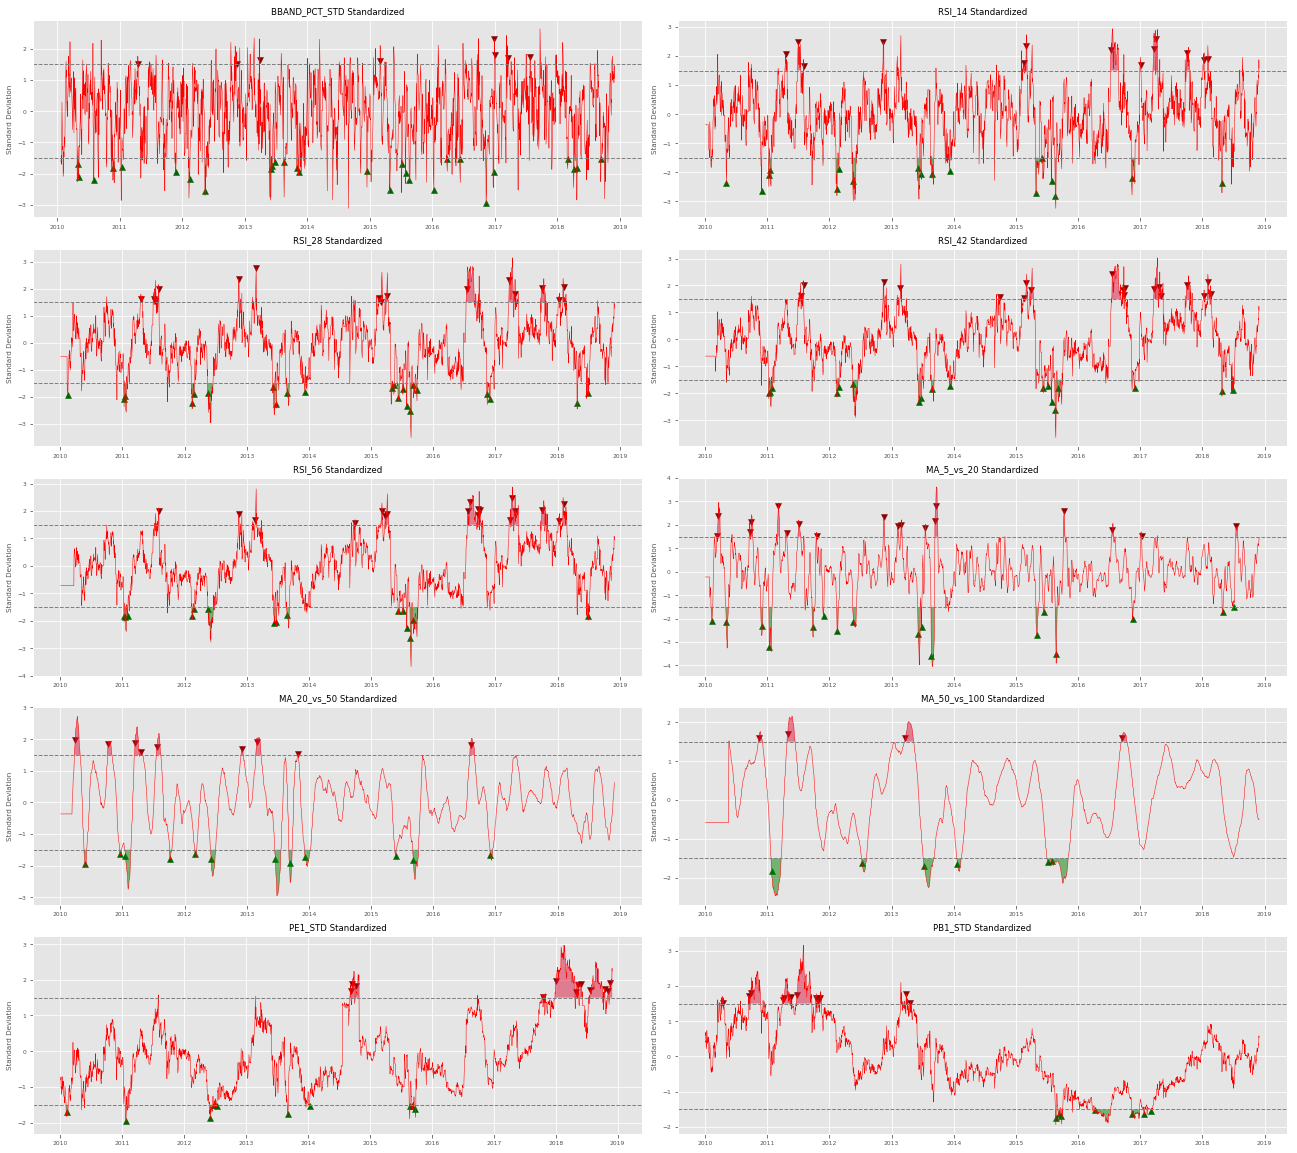

In [71]:
plot_features('BBCA_IJ')

### And plots showing the accuracy and returns of the signals over 1 week/month/quarter ensuing periods.

In [109]:
plot_stats('BBCA_IJ')

![alt text](plot_stats.png "Title")

The accuracy percentage scale is re-centred so that 50% accuracy is zero to make it easier to see which signals are above or below 50% accuracy. They are then ranked by descending accuracy. The table below shows some stats to highlight that accuracy alone should not be the determining ranking factor. For example, the table summarizes the top 5 signals in the 1-Quarter Return Outcomes plot. However, __PE1_STD_buy__ is ranked second after __PB1_STD_buy__ in the plot, but since PE1 has both greater frequency and higher return, its score is higher. Similarly, __RSI_42_buy__ is ranked 5th by accuracy alone, but with higher frequency and returns considered, it scores as 2nd most reliable indicator. 

#### Other things to note:
Almost all the indicators with >50% accuracy are buy signals, and vice versa. This would suggest that BBCA_IJ was an upward trending stock and simply buying the dips would have been a good starting point (indeed the price chart confirms this). Still, it is extremely helpful to know which signal to rely upon when buying dips, and PE stands out as by far the most reliable for this stock. The lowest min return of any PE buy signal for any return outcome period was -0.7%, while the lowest max of any period was 15%, implying a very good risk / reward skew.

Interesting also to note that PE_sell scores 5th for the 1-Quarter Return Outcomes, suggesting it is reasonably good as a two-way indicator.

The scoring method is hastily cobbled together and could likely be improved, but intuitively makes sense for ranking.

Its difficult to avoid duplicate counting of signals, particularly with faster signals, as the level can dip back and forth across the threshold. This has largely been avoided for the 1-week and 1-month return horizons, but is more challenging to deal with for the 1-quarter outcome horizon.

#### Next steps:
With this framework, it is possible to include both a larger universe of stocks and test/evaluate many more technical indicators. There may be interesting findings on which signals are generally good for any stock, which may be good for specific sectors, quality, and which may simply be idiosyncratic to a particular stock. ML clustering could also be considered here.

Finding an ensemble of signals may prove to increase the signal score. Signal frequency drops considerably with more indicators required to be in outlier territory, which in turn can impinge on the reliability of accuracy scores. One possible mitigant worth exploring might be to increase the speed/sensitivity of the indicators such that they become akin to weak learners in a random forest type ensemble, where once combined together they provide a much more robust signal.

Findings here could seen as a form of feature engineering / selection to then use as features in ML models.

With signal scoring, it has been shown that current outliers can be assessed and ranked by signal score to comb the universe for the best potential buys/sells. Proper backtesting needs to be done to better evaluate this as a stock selection methodolgy.

In [120]:
temp = combine_stats('BBCA_IJ', stdev_threshold, window)
temp = temp.loc[ pd.IndexSlice['Quarter', :], pd.IndexSlice['PB1_STD_buy', 'PE1_STD_buy', 'PE1_STD_sell',
                                                          'MA_50_vs_100_buy', 'RSI_42_buy'] ]
temp

PB1_STD_buy  PE1_STD_buy  PE1_STD_sell  \
Quarter Freq             7.000000    11.000000      9.000000   
        Hit Rate         7.000000    11.000000      8.000000   
        Accuracy         1.000000     1.000000      0.888889   
        Mean_Rtn        10.632846    13.396362      4.699338   
        Exp_Rtn         10.632846    13.396362      4.177189   
        Signal_Score    74.429925   147.359983     37.594702   
        Max             16.889632    38.888889      8.202654   
        Min              1.147228     7.065217     -1.802757   
        Stdev            4.894268     8.569959      3.057126   

                      MA_50_vs_100_buy  RSI_42_buy  
Quarter Freq                  6.000000   18.000000  
        Hit Rate              5.000000   15.000000  
        Accuracy              0.833333    0.833333  
        Mean_Rtn              7.687122    9.284455  
        Exp_Rtn               6.405935    7.737046  
        Signal_Score         38.435608  139.266832  
        Max                  27.966102   30.973451  
        Min                 -10.037879  -11.610487  
        Stdev                11.155333   10.626694